# Conditional Logit

- 주된 참고 문헌은 Ruth N. Bolton & Randall G. Chapman, "Searching For Positive Returns at the Track: A Multinomial Logit Model for Handicapping Horse Races"(1986)
- 다범주 로짓 모형을 활용한다면, 경기의 맥락(즉 경쟁 경주마들과 관련된 정보)을 반영할 수 있음
- 아래 공식에서 확인할 수 있듯, 임의의 말이 우승할 확률의 분모에는 경쟁마들의 정보가 들어가기 때문임
- 다범주 로짓의 또 다른 장점은 '확률'을 Return하는 모델이라는 점임
- 이에 따라, 한 경기에 뛰는 모든 경주마의 y값을 합하면 1이 되며 이는 다른 모델들과 대별되는 지점

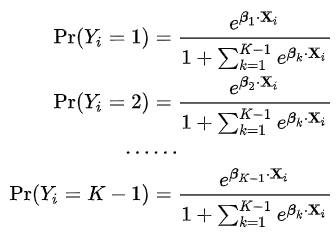

In [2]:
from IPython.display import Image
Image('mlogit.png')

- 한편, 원 논문에서 사용한 변수들은 말의 몸무게, 승률 및 레이팅, 기수의 승률, 레인, 새로운 거리 여부 등이 있었음
- 그러나 본 프로젝트에서는 위의 변수 중 기수의 정보는 사용하지 않았는데, 그 까닭은 기수의 정보까지 사용할 경우 잃게 되는 row의 개수가 컸기 때문
- 그리고 새로운 거리 여부 변수는 Significance가 낮아 제외함
- 더불어, LAP Time 예측에서와 달리 humidity, distance 등의 정보를 사용하지 않았음
- 그 까닭은 해당 변수들은 한 경기를 뛰는 모든 말들이 동일한 값을 가지기 때문임

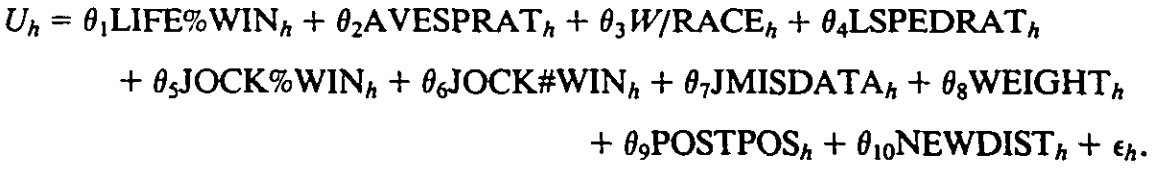

In [3]:
Image('original_model.png')

## Training Data Expansion

- 이 논문이 제공한 또 다른 중요한 방법론은 Training Data를 확장하는 방법임
- 하나의 경기 결과에서 1위 말을 제외하고, 기존의 2위 말이 1위인 것처럼 새로운 경기 조를 만드는 것이 이 방법론의 핵심
- 이렇게 2위, 3위 말이 1위가 되는 가상의 경기 결과를 만들게 된다면, Training Data는 3배로 불어남

In [ ]:
train2 = train[train['rank']!=1]
train2['choice'] = (train2['rank'] == 2).apply(int) # Choice는 해당 경기에서 1위 말에 1을 주는 더미변수
train2['groupid'] = train2['groupid'] + 20000

train3 = train[train['rank']!=2]
train3['choice'] = (train3['rank'] == 3).apply(int)
train3['groupid'] = train3['groupid'] + 40000

train = train.append(train2, ignore_index=True).append(train3, ignore_index=True)

## Conditional Logit Model을 추정하기 위한 준비 작업

1. 종속 변수를 1/0의 형태로 바꿈 - 1위 말에 1을 나머지 말에 0을 부과 (변수를 Choice로 명명)
2. GroupID 변수 생성 - 동일한 경기를 뛴 말들에 대해 동일한 ID를 할당한 변수 > Conditional Logit 추정에 필수적
3. 실격 처리되어 직전 경기 결과 정보가 없는 경우 OR 레이팅 정보가 없는 경우 > false1time, false2time, norating 더미변수 생성

In [ ]:
# Choice
df['choice'] = (df['rank'] == 1).apply(int)

# GroupID
df['groupid'] = df['date'].apply(str) + df['round'].apply(str) + df['location'].apply(str)
idset = list(set(df['groupid']))
give_ids = dict(list(zip(idset, list(range(len(idset))))))
df['groupid'] = df['groupid'].apply(lambda x: give_ids[x])

# FalseNTime
for i in df.index:
    a = df.loc[i, 'prev1_rank']; b = df.loc[i, 'prev2_rank']
    if a != 0 and b != 0:
        df.loc[i, 'prev_rank'] = (a+b)/2
    elif a == 0 and b == 0:
        df.loc[i, 'prev_rank'] = 0
        df.loc[i, 'false2time'] = 1
    else:
        df.loc[i, 'prev_rank'] = a+b
        df.loc[i, 'false1time'] = 1

# NoRating
df['norating'] = (df['horse_level_num'] == -1).apply(int)

## Conditional Logit Train

- 2018년 3월을 기점으로 이전 데이터를 Train 데이터로, 이후 데이터를 Test 데이터로 사용
- 앞서 언급한 방식에 따라 Train 데이터를 확장
- 사용된 독립 변수는 아래와 같음 
- 'lane','horse_level_num','prev_avgrank2','failsin2','nodata','prev_avgvel2','age','raw_weight','jockey_w','weight_diff','dandivi','yeondivi','sex1','sex2','doublefail'

In [6]:
train.head()

,choice,groupid,lane,horse_level_num,prev_avgrank2,failsin2,nodata,prev_avgvel2,age,raw_weight,jockey_w,weight_diff,dandivi,yeondivi,sex1,sex2,doublefail,rank
0,1,0,8.0,4,7.5,0,0,0.990961,4.0,446.0,55.0,-3.0,4.8,1.4,0,1,0,1
1,0,0,6.0,4,7.0,0,0,0.991357,3.0,496.0,54.0,11.0,16.6,3.4,0,1,0,6
2,0,0,2.0,4,6.0,0,0,0.998775,4.0,429.0,51.0,-18.0,23.1,4.1,0,0,0,8
3,0,0,3.0,4,5.5,0,0,0.991784,3.0,503.0,53.0,2.0,5.2,1.8,0,0,0,4
4,0,0,4.0,4,2.0,0,0,0.994573,2.0,469.0,54.0,-6.0,3.8,1.4,1,0,0,7


- Conditional Logit 추정은 STATA를 이용하였음
- 이는 python의 clogit 모듈은 각 경기에 참여한 말의 수가 일정할 때만 사용할 수 있다는 문제점 때문임

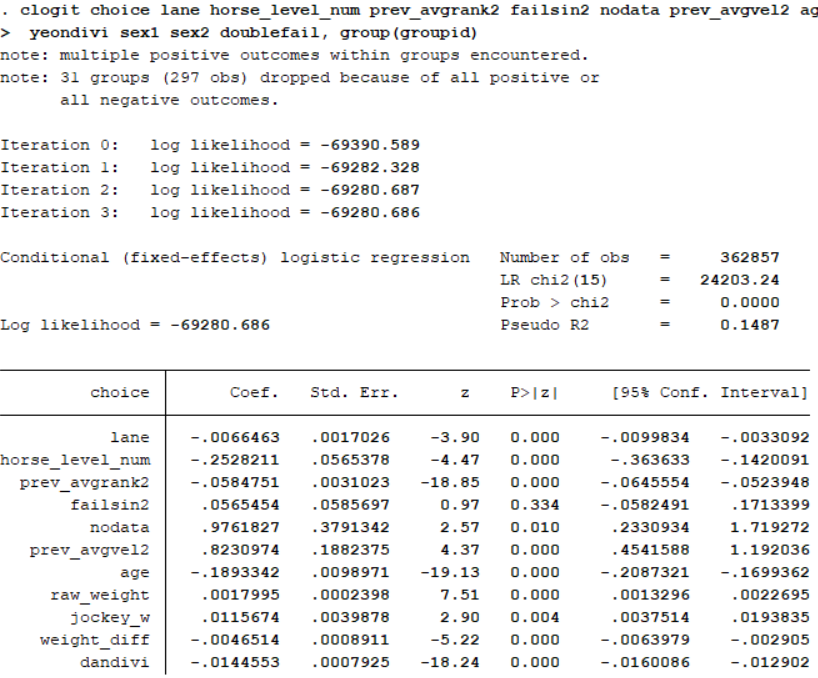

In [13]:
# 모델 추정 결과
Image('clogit1.png', width=600, height=800)

## Conditional Logit Test

- Train Data에 대해 clogit model 추정 후, Test Data를 Feed하여 확률을 예측할 수 있음
- 그 결과는 하기와 같음

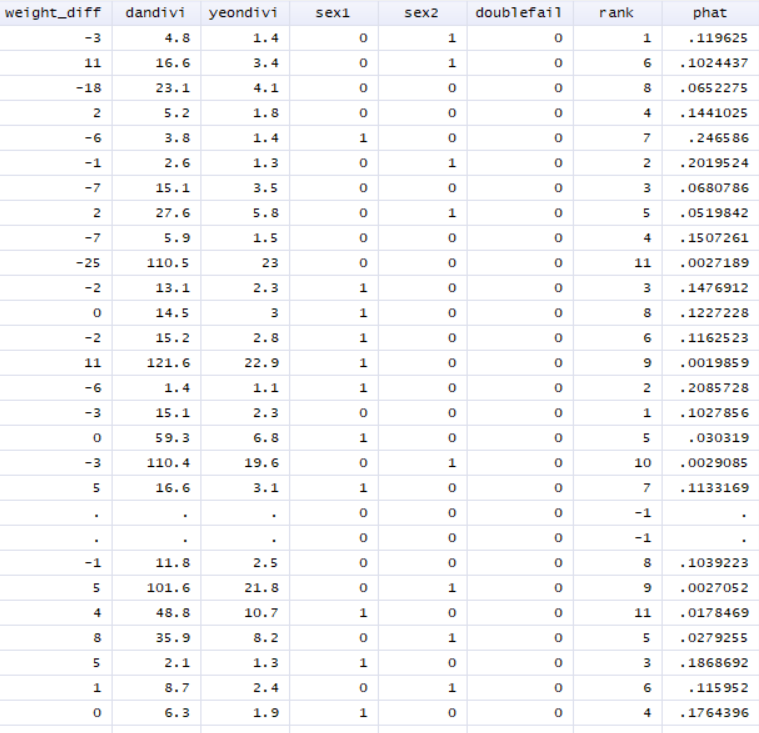

In [15]:
# Test Data에 대한 확률 추정 결과 (phat column)
Image('clogit2.png', width = 500, height=1000)

## Conditional Logit Result

- 예측 결과, 가장 확률이 높은 말이 1등일 확률 - 35%, 2등 이내일 확률 - 54%, 3등 이내일 확률 - 68%로 도출됨
- 이러한 결과는 본질적으로 복수의 Logit 모델이라고 할 수 있는 NN 모델의 필요성을 환기하는 결과라고 할 수 있음

In [102]:
idx = list(set(test_n['groupid']))
dictt=dict(test_n.groupby(['groupid'])['phat'].max())

t1=0; t2=0; t3=0

for i in idx:
    if list(test_n[(test_n['groupid']==i) & (test_n['phat']==dictt[i])]['choice'])[0] == 1:
        t1 = t1 + 1
    if list(test_n[(test_n['groupid']==i) & (test_n['phat']==dictt[i])]['choice2'])[0] == 1:
        t2 = t2 + 1
    if list(test_n[(test_n['groupid']==i) & (test_n['phat']==dictt[i])]['choice3'])[0] == 1:
        t3 = t3 + 1 
        
total = test_n.groupby(['groupid']).max()['choice'].sum(); total2 = test_n.groupby(['groupid']).max()['choice2'].sum()
total3 = test_n.groupby(['groupid']).max()['choice3'].sum()

print(t1 / total)
print(t2 / total2)
print(t3 / total3)

0.3525329632199861
0.5392088827203331
0.6773074253990284
